# Project 4 # 

## Netflix Movies and TV Shows: Clustering ##

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE

# display settings
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

## Loading the Dataset ##

In [90]:
df = pd.read_csv("Netflix_movies_and_tv_shows_clustering.csv")

# Display the first few rows
print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Data Prep ##

In [93]:
print("Missing values per column:\n", df.isnull().sum())
df = df.dropna(subset=['title', 'listed_in'])
df = df.fillna('Unknown')
df = df.drop_duplicates()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print("\nCleaned dataset shape:", df.shape)
df.head()

Missing values per column:
 show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

Cleaned dataset shape: (7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Feature Selection and Encoding ##

In [96]:
# Select key features for clustering
features = df[['type', 'release_year', 'rating', 'duration', 'listed_in']].copy()

# Clean up duration column (convert minutes or seasons into numeric form)
def convert_duration(x):
    if 'min' in x:
        return int(x.replace('min', '').strip())
    elif 'Season' in x:
        return int(x.replace('Seasons', '').replace('Season', '').strip()) * 60  # approx 60 min per episode
    else:
        return 0

features['duration'] = features['duration'].apply(convert_duration)

# Label Encode categorical columns
label_cols = ['type', 'rating']
encoder = LabelEncoder()
for col in label_cols:
    features[col] = encoder.fit_transform(features[col])

# For 'listed_in' (genres/categories), use simple one-hot encoding
genres_encoded = features['listed_in'].str.get_dummies(sep=', ')

# Combine all processed features
X = pd.concat([features.drop(columns=['listed_in']), genres_encoded], axis=1)

print("Processed feature set shape:", X.shape)
X.head()

Processed feature set shape: (7787, 46)


,type,release_year,rating,duration,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,1,2020,8,240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,0,2016,8,93,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2011,5,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2009,4,80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2008,4,123,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Apply K-Means Clustering  ##

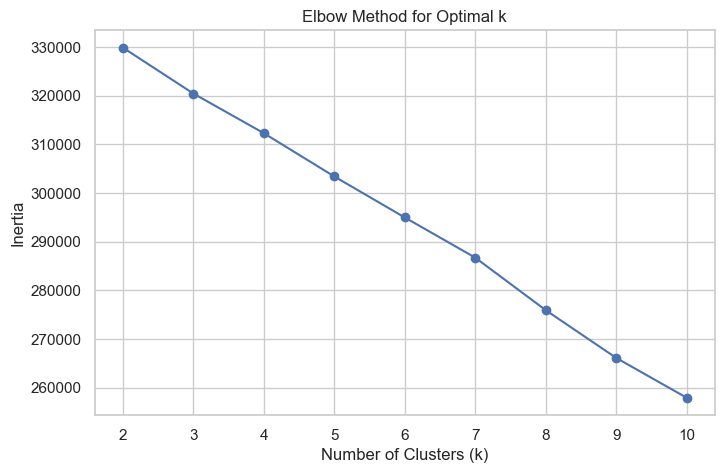

cluster
0    4791
2    1708
1     700
4     532
3      56
Name: count, dtype: int64


,title,type,release_year,listed_in,cluster
0,3%,TV Show,2020,"International TV Shows, TV Dramas, TV Sci-Fi &...",2
1,7:19,Movie,2016,"Dramas, International Movies",0
2,23:59,Movie,2011,"Horror Movies, International Movies",0
3,9,Movie,2009,"Action & Adventure, Independent Movies, Sci-Fi...",0
4,21,Movie,2008,Dramas,0
5,46,TV Show,2016,"International TV Shows, TV Dramas, TV Mysteries",2
6,122,Movie,2019,"Horror Movies, International Movies",0
7,187,Movie,1997,Dramas,0
8,706,Movie,2019,"Horror Movies, International Movies",0
9,1920,Movie,2008,"Horror Movies, International Movies, Thrillers",0


In [99]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Let's assume k=5 based on elbow curve (you can adjust later)
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Display the number of titles in each cluster
print(df['cluster'].value_counts())

# Preview some cluster assignments
df[['title', 'type', 'release_year', 'listed_in', 'cluster']].head(10)


## Apply Agglomerative Clustering ##

Agglomerative Cluster Counts:
cluster_agg
1    3760
0    1468
4    1317
3    1093
2     149
Name: count, dtype: int64

Agglomerative Silhouette Score: 0.0907
Adjusted Rand Index (K-Means vs Agglomerative): 0.451


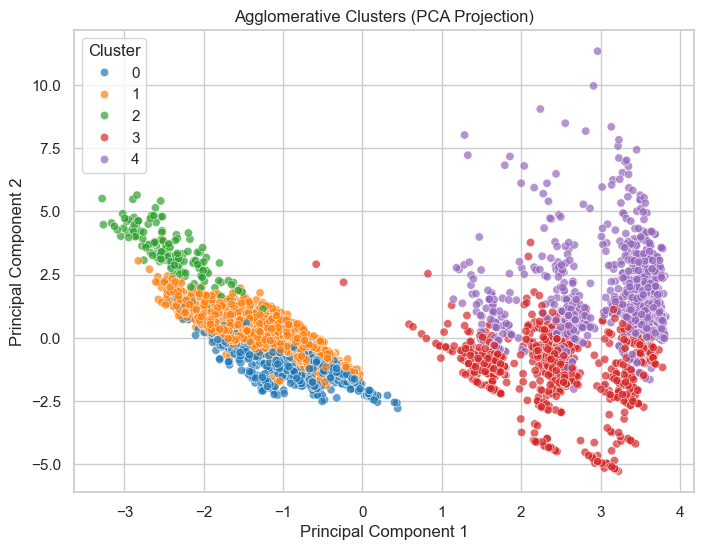

In [102]:
# Use the same number of clusters as K-Means
n_clusters = 5

# Create and fit the Agglomerative Clustering model
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['cluster_agg'] = agg.fit_predict(X_scaled)

# Display the number of titles in each Agglomerative cluster
print("Agglomerative Cluster Counts:")
print(df['cluster_agg'].value_counts())

# Calculate silhouette score to evaluate cluster separation
silhouette_agg = silhouette_score(X_scaled, df['cluster_agg'])
print("\nAgglomerative Silhouette Score:", round(silhouette_agg, 4))

if 'cluster' in df.columns:  # assuming K-Means cluster column is named 'cluster'
    ari_score = adjusted_rand_score(df['cluster'], df['cluster_agg'])
    print("Adjusted Rand Index (K-Means vs Agglomerative):", round(ari_score, 4))


# Reduce data to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster_agg'] = df['cluster_agg']

# Plot Agglomerative clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster_agg',
    palette='tab10',
    data=pca_df,
    alpha=0.7
)
plt.title("Agglomerative Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Cluster Analysis and Visualization ##

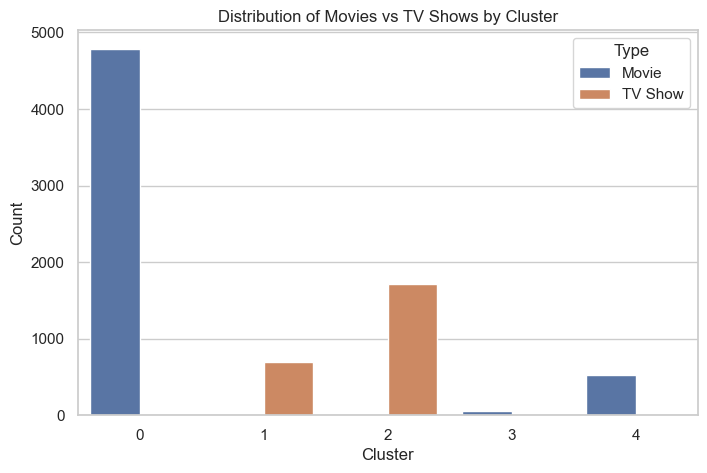

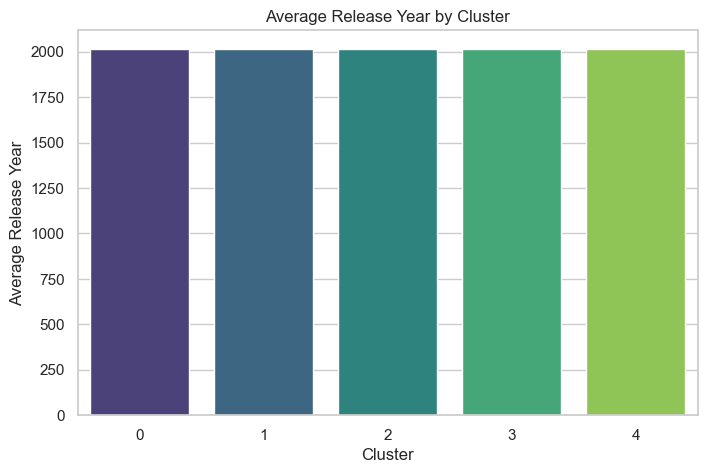

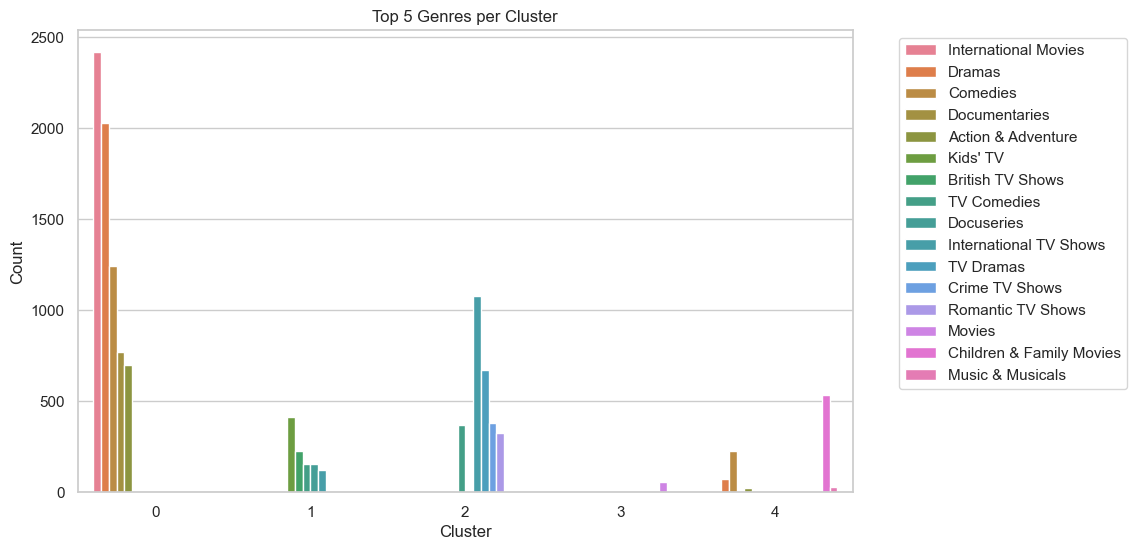

In [105]:
# Distribution of types in each cluster
plt.figure(figsize=(8,5))
sns.countplot(x='cluster', hue='type', data=df)
plt.title('Distribution of Movies vs TV Shows by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

# Average release year per cluster
cluster_years = df.groupby('cluster')['release_year'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='cluster', y='release_year', data=cluster_years, palette='viridis')
plt.title('Average Release Year by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Release Year')
plt.show()

# Top genres per cluster
top_genres = (
    df.groupby('cluster')['listed_in']
      .apply(lambda x: ', '.join(x))
      .apply(lambda x: pd.Series(x.split(', ')))
      .stack()
      .reset_index(level=1, drop=True)
      .to_frame('genre')
      .reset_index()
)
top_genres = top_genres.groupby(['cluster', 'genre']).size().reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(data=top_genres.sort_values('count', ascending=False).groupby('cluster').head(5),
            x='cluster', y='count', hue='genre')
plt.title('Top 5 Genres per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Evaluating ##

In [126]:
if 'cluster_kmeans' not in df.columns and 'cluster' in df.columns:
    df.rename(columns={'cluster': 'cluster_kmeans'}, inplace=True)

# Silhouette score (how well-separated clusters are)
sil = silhouette_score(X_scaled, df['cluster_kmeans'])
print("KMeans Silhouette Score:", round(sil, 4))

silhouette_agg = silhouette_score(X_scaled, df['cluster_agg'])
print("\nAgglomerative Silhouette Score:", round(silhouette_agg, 4))

# Compare with Agglomerative
if 'cluster_agg' in df.columns:
    ari = adjusted_rand_score(df['cluster_kmeans'], df['cluster_agg'])
    print("Adjusted Rand Index (KMeans vs Agglomerative):", round(ari, 4))
else:
    print("No Agglomerative clustering found — skipping ARI.")

KMeans Silhouette Score: 0.0852

Agglomerative Silhouette Score: 0.0907
Adjusted Rand Index (KMeans vs Agglomerative): 0.451


## Clean duration column and profile clusters ##

In [121]:
# Convert 'duration' into numeric minutes (for movies only)
def clean_duration(val):
    if pd.isna(val):
        return None
    if 'min' in val:
        try:
            return int(val.split(' ')[0])
        except:
            return None
    else:
        return None

df['duration_min'] = df['duration'].apply(clean_duration)

# ✅ FIXED VERSION of the cluster profiling function
def cluster_profile(df, cluster_col='cluster_kmeans', top_n_genres=3):
    profiles = {}
    for c in sorted(df[cluster_col].unique()):
        d = df[df[cluster_col] == c]
        top_genres = (
            d['listed_in']
            .dropna()
            .str.split(', ')
            .explode()
            .value_counts()
            .head(top_n_genres)
            .to_dict()
        )
        avg_year = round(d['release_year'].mean(), 1)
        avg_dur = round(d['duration_min'].dropna().mean(), 1) if d['duration_min'].notna().any() else None
        type_pct = (d['type'].value_counts(normalize=True) * 100).round(1).to_dict()
        rating_top = d['rating'].value_counts().head(5).to_dict()
        
        profiles[c] = {
            'count': len(d),
            'top_genres': top_genres,
            'avg_release_year': avg_year,
            'avg_duration_min': avg_dur,
            'type_distribution_%': type_pct,
            'top_ratings': rating_top
        }
    return profiles

# Generate and display profiles
profiles = cluster_profile(df)
import pprint
pprint.pprint(profiles)


{np.int32(0): {'avg_duration_min': np.float64(102.1),
               'avg_release_year': np.float64(2012.8),
               'count': 4791,
               'top_genres': {'Comedies': 1246,
                              'Dramas': 2031,
                              'International Movies': 2418},
               'top_ratings': {'PG-13': 375,
                               'R': 662,
                               'TV-14': 1255,
                               'TV-MA': 1835,
                               'TV-PG': 424},
               'type_distribution_%': {'Movie': 100.0, 'TV Show': 0.0}},
 np.int32(1): {'avg_duration_min': None,
               'avg_release_year': np.float64(2015.3),
               'count': 700,
               'top_genres': {'British TV Shows': 227,
                              "Kids' TV": 414,
                              'TV Comedies': 156},
               'top_ratings': {'TV-14': 66,
                               'TV-MA': 116,
                               'TV-PG': 12

## Visualizing the Clusters ##

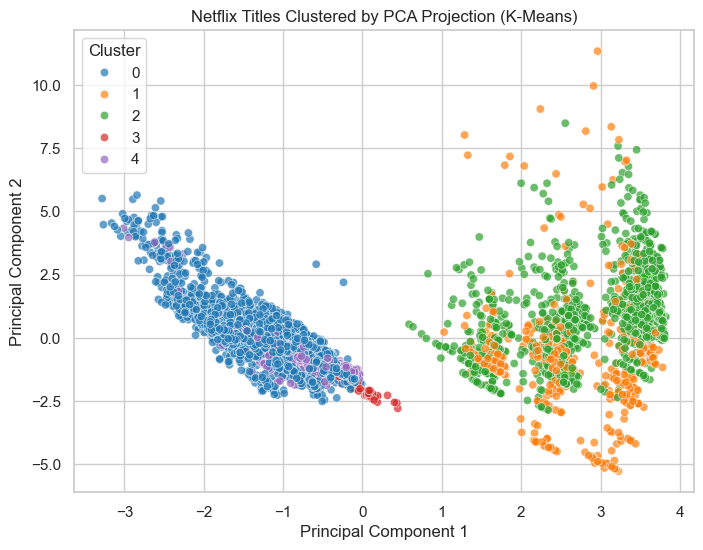

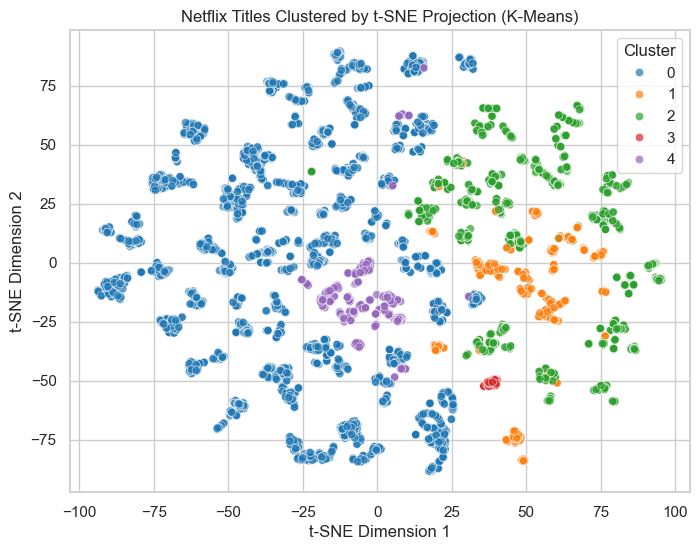

In [124]:
# Reduce data to 2 principal components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = df['cluster_kmeans']

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',
    alpha=0.7
)
plt.title('Netflix Titles Clustered by PCA Projection (K-Means)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = df['cluster_kmeans']

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette='tab10',
    alpha=0.7
)
plt.title('Netflix Titles Clustered by t-SNE Projection (K-Means)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()